In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json


In [3]:
torch.cuda.is_available()

True

In [4]:
torch.backends.cudnn.enabled

True

## Dataset

In [5]:
PATH = Path('/home/ubuntu/fastai/data/roads/mass_roads_png_128')
os.listdir(PATH)

['train', 'tmp', 'models', 'valid', 'test']

In [6]:
sz = 128
bs = 64

aug_tfms = []

In [7]:
TRAIN_DATA_x = '{}/train/sat'.format(PATH)
TRAIN_DATA_y = '{}/train/map'.format(PATH)
trn_x = glob(os.path.join(TRAIN_DATA_x, "*.png"))
trn_y = glob(os.path.join(TRAIN_DATA_y, "*.png"))
#train_ids_150 = [s[len(TRAIN_DATA)+1:-5] for s in train_files_150]
#train_ids_150[:5]

In [8]:
TRAIN_DATA_x

'/home/ubuntu/fastai/data/roads/mass_roads_png_128/train/sat'

In [9]:
!ls {TRAIN_DATA_x} | wc -l

7014


In [10]:
VALID_DATA_x = '{}/valid/sat'.format(PATH)
VALID_DATA_y = '{}/valid/map'.format(PATH)
val_x = glob(os.path.join(VALID_DATA_x, "*.png"))
val_y = glob(os.path.join(VALID_DATA_y, "*.png"))


In [11]:
trn_x[:10]

['/home/ubuntu/fastai/data/roads/mass_roads_png_128/train/sat/23579050_15_2.png',
 '/home/ubuntu/fastai/data/roads/mass_roads_png_128/train/sat/19978630_15_4.png',
 '/home/ubuntu/fastai/data/roads/mass_roads_png_128/train/sat/23728825_15_2.png',
 '/home/ubuntu/fastai/data/roads/mass_roads_png_128/train/sat/22679050_15_13.png',
 '/home/ubuntu/fastai/data/roads/mass_roads_png_128/train/sat/23279170_15_14.png',
 '/home/ubuntu/fastai/data/roads/mass_roads_png_128/train/sat/20128945_15_0.png',
 '/home/ubuntu/fastai/data/roads/mass_roads_png_128/train/sat/23279155_15_15.png',
 '/home/ubuntu/fastai/data/roads/mass_roads_png_128/train/sat/22679005_15_10.png',
 '/home/ubuntu/fastai/data/roads/mass_roads_png_128/train/sat/10228735_15_3.png',
 '/home/ubuntu/fastai/data/roads/mass_roads_png_128/train/sat/11128900_15_4.png']

In [12]:
img = Image.open(val_y[0])
np.asarray(img).shape

(128, 128)

In [13]:
img = Image.open(trn_y[0])
np.asarray(img).shape

(128, 128)

In [14]:
print('Len train sat: {} len train mask: {}'.format(len(trn_x), len(trn_y)))
print('Len valid sat: {} Len Valid mask: {}'.format(len(val_x), len(val_y)))

Len train sat: 7014 len train mask: 7014
Len valid sat: 460 Len Valid mask: 460


In [15]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): return open_image(os.path.join(self.path, self.y[i]))
    def get_c(self): return 0

In [16]:
arch=resnet34
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=[])
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=8, classes=None)

In [17]:
denorm = md.trn_ds.denorm
x,y = next(iter(md.aug_dl))
x = denorm(x)
y = to_np(y)

In [18]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

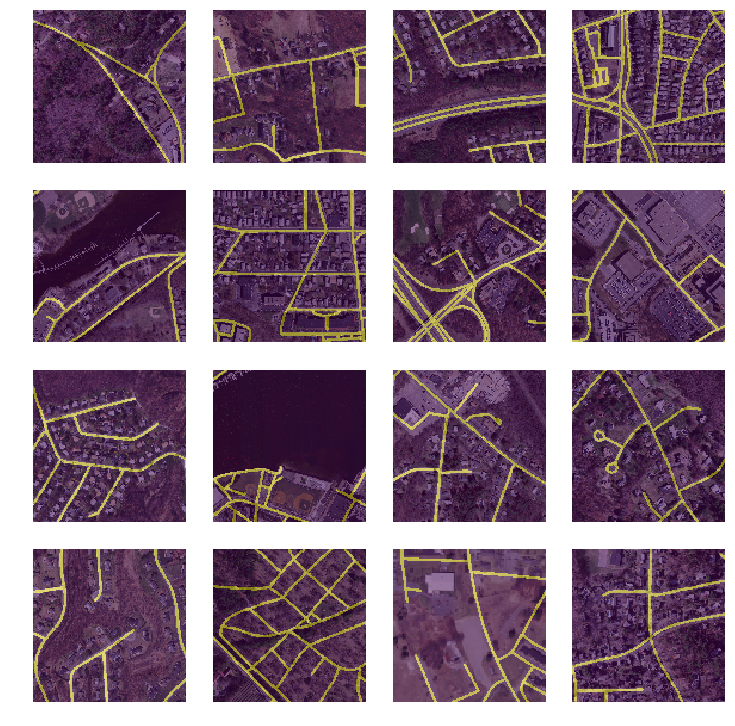

In [19]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i,ax in enumerate(axes.flat):
    show_img(x[i], ax=ax)
    show_img(y[i], ax=ax, alpha=0.5)
plt.tight_layout(pad=0.1)

## Model

In [20]:
class StdUpsample(nn.Module):
    def __init__(self, nin, nout):
        super().__init__()
        self.conv = nn.ConvTranspose2d(nin, nout, 2, stride=2)
        self.bn = nn.BatchNorm2d(nout)
        
    def forward(self, x): return self.bn(F.relu(self.conv(x)))

In [21]:
flatten_channel = Lambda(lambda x: x[:,0])

In [22]:
simple_up = nn.Sequential(
    nn.ReLU(),
    StdUpsample(512,256),
    StdUpsample(256,256),
    StdUpsample(256,256),
    StdUpsample(256,256),
    nn.ConvTranspose2d(256, 1, 2, stride=2),
    flatten_channel
)

In [29]:
models = ConvnetBuilder(resnet34, 0, 0, 0, custom_head=simple_up)
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5)]

In [30]:
learn.lr_find()
learn.sched.plot()

KeyError: <weakref at 0x7f88444eebd8; to 'tqdm' at 0x7f884447a358>

In [31]:
# This doesn't look too good.  Just picked something that might work here.
lr=5e-2

In [32]:
learn.fit(lr,1,cycle_len=5,use_clr=(20,5))

 18%|█▊        | 20/110 [00:06<00:31,  2.87it/s, loss=0.294]
epoch      trn_loss   val_loss   <lambda>                    
    0      0.295797   0.290813   0.911415  
    1      0.294942   0.291413   0.911415                    
    2      0.29514    0.290944   0.911415                    
    3      0.294595   0.290998   0.911415                    
    4      0.292956   0.291378   0.911415                    



[0.29137796137643895, 0.9114152986070384]

 82%|████████▏ | 90/110 [00:29<00:06,  3.03it/s, loss=1.22] 

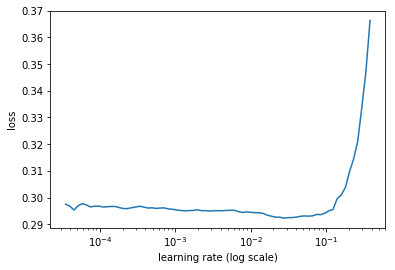

In [28]:
learn.lr_find()
learn.sched.plot()


In [29]:
learn.save('128')

In [30]:
learn.load('128')

In [31]:
py,ay = learn.predict_with_targs()

In [32]:
ay.shape

(460, 128, 128)

In [33]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

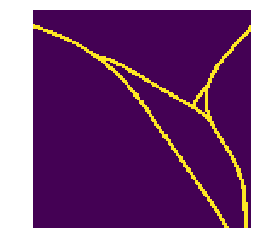

In [34]:
show_img(ay[0])

In [35]:
ay[0]


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [36]:
py[0]

array([[-2.5031 , -2.49415, -2.38576, ..., -2.55706, -2.39754, -2.40121],
       [-2.42264, -2.45831, -2.31486, ..., -2.5244 , -2.29604, -2.41797],
       [-2.52656, -2.51792, -2.49844, ..., -2.53387, -2.3926 , -2.3876 ],
       ...,
       [-2.54975, -2.6016 , -2.58508, ..., -2.12812, -2.07104, -2.08849],
       [-2.73385, -2.7181 , -2.5798 , ..., -2.06849, -2.10265, -2.10186],
       [-2.73027, -2.65543, -2.42634, ..., -2.10613, -2.1174 , -2.11832]], dtype=float32)

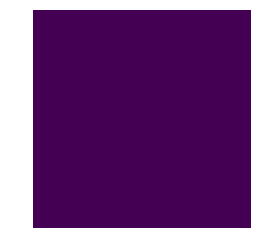

In [37]:
show_img(py[0]>0);

In [44]:
learn.unfreeze()

In [45]:
learn.bn_freeze(True)

In [46]:
lrs = np.array([lr/100,lr/10,lr])/4

In [47]:
learn.fit(lrs,1,cycle_len=8,use_clr=(20,8))

epoch      trn_loss   val_loss   <lambda>                       
    0      4.6061827977055286e+20 1183.350959 0.866688  
    1      4.503277572927796e+19 1947.978316 0.812689           
 34%|███▎      | 37/110 [00:23<00:45,  1.59it/s, loss=2.12e+19]

KeyboardInterrupt: 

In [39]:
learn.save('128')

In [40]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

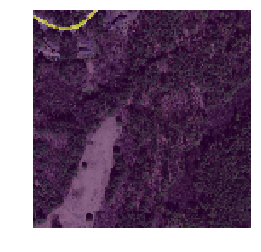

In [41]:
denorm = md.trn_ds.denorm
ax = show_img(denorm(x)[0])
show_img(py[0]>0, ax=ax, alpha=0.5);

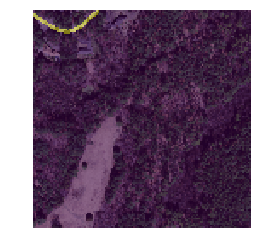

In [42]:
ax = show_img(denorm(x)[0])
show_img(y[0], ax=ax, alpha=0.5);

## 512x512

In [5]:
PATH = Path('/home/ubuntu/fastai/data/roads/mass_roads_png_512')
os.listdir(PATH)
sz = 512
bs = 16

In [6]:
TRAIN_DATA_x = '{}/train/sat'.format(PATH)
TRAIN_DATA_y = '{}/train/map'.format(PATH)
trn_x = glob(os.path.join(TRAIN_DATA_x, "*.png"))
trn_y = glob(os.path.join(TRAIN_DATA_y, "*.png"))

VALID_DATA_x = '{}/valid/sat'.format(PATH)
VALID_DATA_y = '{}/valid/map'.format(PATH)
val_x = glob(os.path.join(VALID_DATA_x, "*.png"))
val_y = glob(os.path.join(VALID_DATA_y, "*.png"))


In [9]:
arch=resnet34
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=[])
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=8, classes=None)

In [10]:
denorm = md.trn_ds.denorm
x,y = next(iter(md.aug_dl))
x = denorm(x)

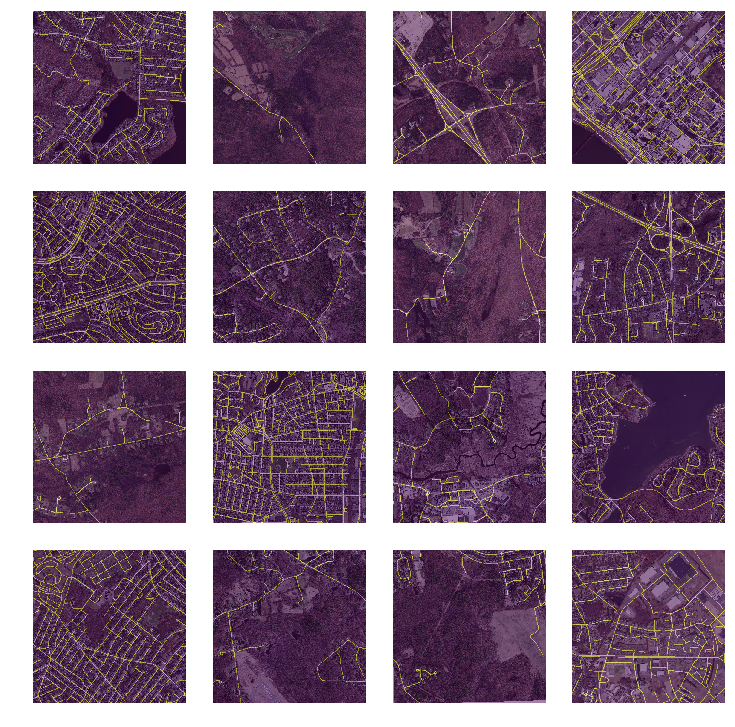

In [13]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i,ax in enumerate(axes.flat):
    ax=show_img(x[i], ax=ax)
    show_img(y[i], ax=ax, alpha=0.5)
plt.tight_layout(pad=0.1)

In [18]:
simple_up = nn.Sequential(
    nn.ReLU(),
    StdUpsample(512,256),
    StdUpsample(256,256),
    StdUpsample(256,256),
    StdUpsample(256,256),
    nn.ConvTranspose2d(256, 1, 2, stride=2),
    flatten_channel
)

In [22]:
# Don't actually understand this bit of code. :(

models = ConvnetBuilder(resnet34, 0, 0, 0, custom_head=simple_up)
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5)]

In [20]:
learn.load('128')

 81%|████████▏ | 57/70 [01:06<00:15,  1.17s/it, loss=1.05] 

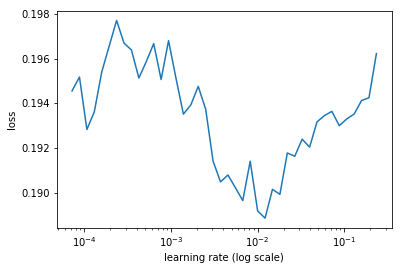

In [24]:
learn.lr_find()
learn.sched.plot()

In [25]:
# Set the learning rate from above plot
lr=1e-2

In [31]:
learn.fit(lr,1,cycle_len=10,use_clr=(20,10))

epoch      trn_loss   val_loss   <lambda>                  
    0      0.176254   0.188486   0.948119  
    1      0.17782    0.187918   0.948119                  
    2      0.178511   0.190261   0.948119                  
    3      0.177809   0.197251   0.948119                  
    4      0.176262   0.195155   0.948118                  
    5      0.175777   0.194096   0.948119                  
    6      0.177989   0.188955   0.948117                  
    7      0.176459   0.188895   0.948119                  
    8      0.175749   0.187334   0.948119                  
    9      0.173688   0.186839   0.948119                  



[0.1868392593330807, 0.9481192155489846]

In [32]:
learn.save('tmp')

In [33]:
learn.load('tmp')

In [34]:
learn.unfreeze()
learn.bn_freeze(True)

In [35]:
lrs = np.array([lr/100,lr/10,lr])/4

In [ ]:
learn.fit(lrs,1,cycle_len=20,use_clr=(20,10))

epoch      trn_loss   val_loss   <lambda>                  
    0      0.171606   0.178165   0.948119  
    1      0.168461   0.171245   0.948119                  
    2      0.16957    0.175464   0.948119                  
    3      0.163903   0.168871   0.948119                  
    4      0.162427   0.170274   0.948119                  
    5      0.158413   0.164974   0.948119                  
    6      0.158665   0.165641   0.948119                  
    7      0.155349   0.162327   0.948119                  
    8      0.15514    0.162132   0.948119                  
    9      0.157167   0.161129   0.94812                   
    10     0.153873   0.16325    0.948119                  
    11     0.15069    0.16052    0.948119                  
    12     0.152676   0.159796   0.94812                   
    13     0.150603   0.160871   0.948119                  
    14     0.151091   0.159066   0.948119                  
    15     0.149119   0.159348   0.948119               

In [60]:
learn.save('512')

In [61]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

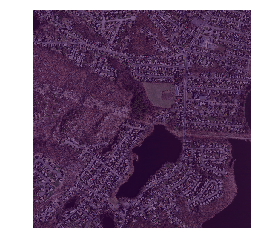

In [66]:
ax = show_img(denorm(x)[0])
show_img(py[0]>0, ax=ax, alpha=0.5);

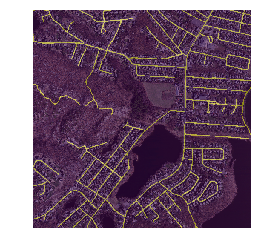

In [65]:
ax = show_img(denorm(x)[0])
show_img(y[0], ax=ax, alpha=0.5);

## 1024x1024